[Qiskit Shor's ](https://learn.qiskit.org/course/ch-algorithms/shors-algorithm)

Shor’s algorithm is famous for factoring integers in polynomial time. Since the best-known classical algorithm requires greater-than-polynomial time to factor the product of two primes, the widely used cryptographic protocol, RSA, relies on factoring being impossible for large enough integers.
In this chapter we will focus on the quantum part of Shor’s algorithm, which actually solves the problem of period finding. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of $a^xmodN$ efficiently, then we can also efficiently factor. Since period finding is a worthy problem in its own right, we will first solve this, then discuss how this can be used to factor in section 5.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


# 1. The Problem: Period Finding
Let's look at the periodic function:
$$f(X) = a^xmodN$$
where a and N are positive integers, a is less than N, and they have no common factors. The period, or order (r), is the smallest (non-zero) integer such that:
$$a^rmodN = 1$$
We can see an example of this function plotted on the graph below. Note that the lines between points are to help see the periodicity and do not represent the intermediate values between the x-markers.

11


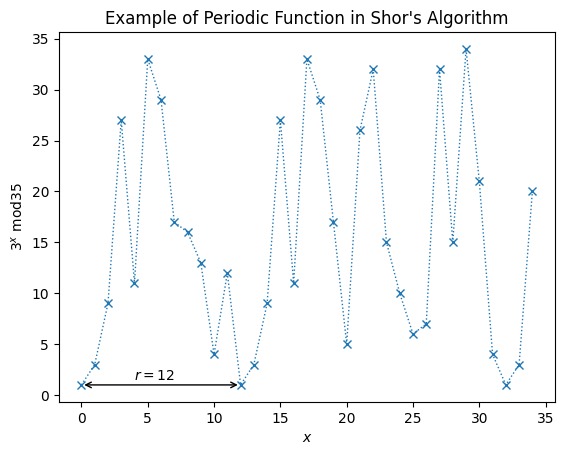

In [6]:
N = 35
a = 3
# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals,yvals,linewidth = 1, linestyle = 'dotted', marker = 'x')
ax.set(xlabel = '$x$', ylabel=f'${a}^x$ mod${N}$', title = "Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('',xy = (0,1),xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a<N and have no common factors.')

## The Solution
Shor’s solution was to use quantum phase estimation on the unitary operator:
$$U\Ket{y} \equiv \Ket{ay mod N}$$
To see how this is helpful, let’s work out what an eigenstate of U might look like. If we started in the state $\Ket{1}$ , we can see that each successive application of U will multiply the state of our register by $a (mod N)$, and after $r$ applications we will arrive at the state $\Ket{1}$ again. For example with $a=3$ and $N=35$ :
$$U\Ket{1} = \Ket{3*1mod35}=\Ket{3}$$
$$U^2\Ket{1} = \Ket{3^2*1mod35}=\Ket{9}$$
$$U^3\Ket{1} = \Ket{3^3*1mod35}=\Ket{27}$$
$$U^4\Ket{1} = \Ket{3^4*1mod35} = =\Ket{11}$$
$$U^(r-1)\Ket{1} = \Ket{3^{r-1}*1mod35}=\Ket{12}$$
$$U^r\Ket{1} = \Ket{3^r*1mod35}=\Ket{1}$$


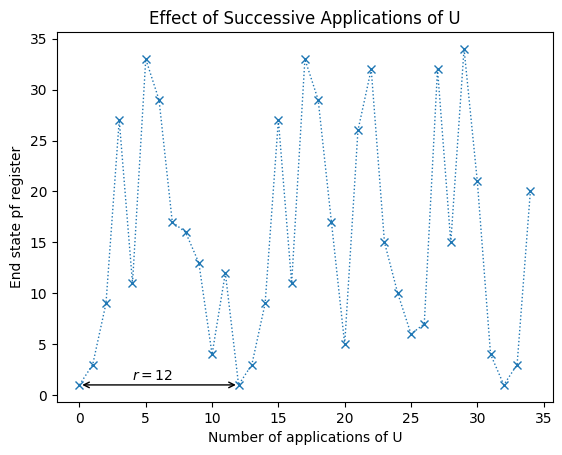

In [7]:
ax.set(xlabel = 'Number of applications of U', ylabel = 'End state of register', title='Effect of Successive Applications of U')
fig

So a superposition of the states in this cycle $\Ket{u_0}$ would be an eigenstate of U:
$$\Ket{u_0}=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}\Ket{a^kmodN}$$
![superposition](./resources/Superposition_of_cycle_state.png)
This eigenstate has an eigenvalue of 1, which isn't very interesting. A more interesting eigenstate could be one in which the phase is different for each of these computational basis states. Specifically, let's look at the case in which the phase of the $k^th$ state is proportional of $k$:
$$\Ket{u_1}=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{-\frac{2\pi i k}{r}}\Ket{a^kmodN}$$
$$U\Ket{u_1}=e^{-\frac{2\pi i}{r}}\Ket{u_1}$$
![example](./resources/shor_tutorial_1.png)
This is a particularly interesting eigenvalue as it contains $r$. In fact, $r$ has to be included to make sure the phase differences between the $r$ computational basis states are equal. This is not the only eigenstate with this behaviour; to generalise this further, we can multiply an integer, $s$, to this phase difference, which will show up in our eigenvalue:
$$\Ket{u_s}=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{-\frac{2\pi i sk}{r}}\Ket{a^kmodN}$$
$$U\Ket{u_s}=e^{-\frac{2\pi is}{r}}\Ket{u_s}$$
![example](./resources/shor_tutorial_2.png)
We now have a unique eigenstate for each integer value of $s$ where $0\leq s \leq r-1$. Very conveniently, if we sum up all these eigenstates, the different phases cancel out all computational basis states except $\Ket{1}$:
$$\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}\Ket{u_s} = \Ket{1}$$
![example](./resources/shor_tutorial_3.png)
Since the computational basis state $\Ket{1}$ is a superposition of these eigenstates, which means if we do QPE on U using the state $\Ket{1}$, we will measure a phase:
$$\phi = \frac{s}{r}$$
Where s is a random integer between 0 and r. We finally use the continued fractions algorithm on $\phi$ to find r. The circuit diagram looks like this (note that this diagram uses Qiskit's qubit ordering convention):
![example](./resources/shor_tutorial_4.png)
We will next demonstrate Shor’s algorithm using Qiskit’s simulators. For this demonstration we will provide the circuits for U without explanation, but in section 4 we will discuss how circuits for $U^{2^j}$ can be constructed efficiently.

## 3. Qiskit Implementation
In this example we will solve period finding problem for a = 7 and N=15. We provide the circuits for U where:
$$U\Ket{y} = \Ket{aymod15}$$

without explanation. To create $U^x$, we will simply repeat the circuit x times. In the next section we will discuss a general method for creating these circuits efficiently. The function c_amod15 returns the controlled-U gate for a, repeated power times.

In [3]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U


In [4]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [5]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

With these building blocks we can easily construct the circuit for Shor's algorithm:

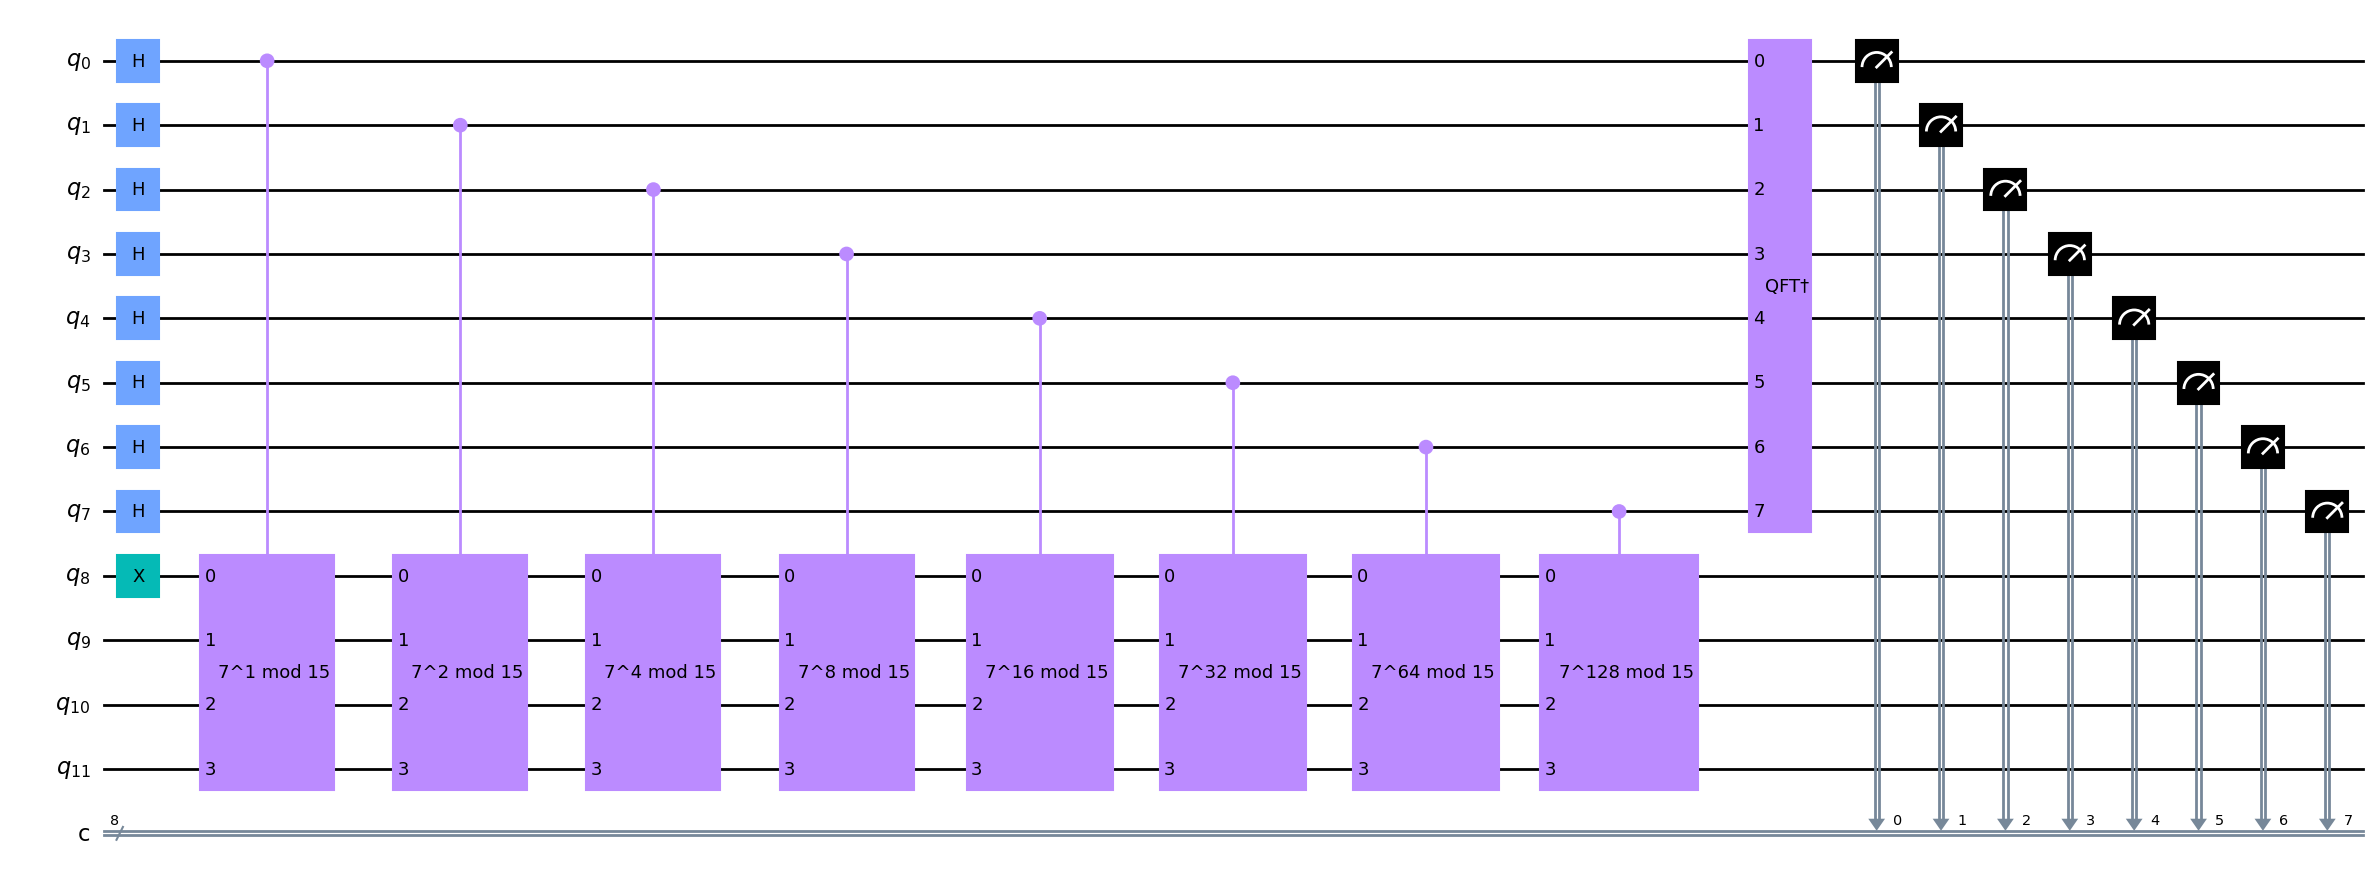

In [6]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT+4, N_COUNT)

#Initialize counting qubits
# In state |+>
for  q in range(N_COUNT):
    qc.h(q)

# and auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled_U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
              [q] + [i+N_COUNT for i in range(4)])
# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))
# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw('mpl',fold=-1)  # -1 means 'do not fold'

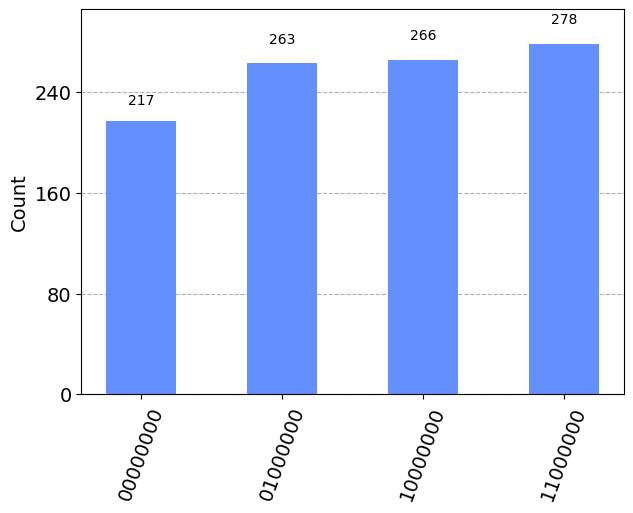

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc,aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

Since we have 8 qubits, these results correspond to measured phases of:

In [8]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  00000000(bin) =   0(dec)    0/256 = 0.00


We can now use the continued fractions algorithm to attempt to find $s$ and $r$. Python has this functionality built in: We can use the fractions module to turn a float into a Fraction object, for example:

In [9]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [10]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.25      1/4            4
2   0.75      3/4            4
3   0.00      0/1            1


# 4. Modular Exponentiation

You may have noticed that the method of creating the $U^{2^j}$ gates by repeating U grows exponentially with j and will not result in a polynomial time algorithm. We want a way to create the operator:
$$U^{2^j}\Ket{y} = \Ket{a^{2^j}ymodN}$$
that grows polynomially with j. Fortunately, calculating:
$$a^{2^j}modN$$
efficiently is possible. Classical computers can use an algorithm known as repeated squaring to calculate an exponential. In our case, since we are only dealing with exponentials of the form $2^j$, the repeated squaring algorithm becomes very simple:


In [11]:
def a2jmonN(a,j,N):
    """Compute a^{2^j} (modN) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2,N)
    return a

In [12]:
a2jmonN(7,2049,53)

47

## 5. Factoring from Period Finding
Not all factoring problems are difficult; we can spot an even number instantly and know that one of its factors is 2. In fact, there are specific criteria for choosing numbers that are difficult to factor, but the basic idea is to choose the product of two large prime numbers.
A general factoring algorithm will first check to see if there is a shortcut to factoring the integer (is the number even? Is the number of the form $N=a^b$
?), before using Shor’s period finding for the worst-case scenario. Since we aim to focus on the quantum part of the algorithm, we will jump straight to the case in which N is the product of two primes.

### Example:Factoring 15
To see an example of factoring on a small number of qubits, we will factor 15, which we all know is the product of the not-so-large prime numbers 3 and 5.

In [13]:
N = 15

The first step is to choose a random number, $a$, between $1$ and $N-1$:

In [15]:
np.random.seed(1)# This is to make sure we get reproduceable results
a = randint(2,15)
print(a)

7


Next we quickly check it isn't already a non-trivial factor of  $N$:

In [21]:
from math import gcd
gcd(a,N)

1

Great. Next, we do Shor's order finding algorithm for a = 7 and N = 15. Remember that the phase we measure will be $\frac{s}{r}$ where:
$$a^rmodN = 1$$
and $s$ is a random integer between 0 and r-1.

In [22]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                  [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

From this phase, we can easily find a guess for r:

In [24]:
a =7
phase = qpe_amod15(a) # Phase =s/r
Fraction(phase).limit_denominator(15)

Register Reading: 00000000
Corresponding Phase: 0.0


Fraction(0, 1)

In [25]:
frac= Fraction(phase).limit_denominator(15)
s, r = frac.numerator,frac.denominator
print(r)

1


Now we have r, we might be able to use this to find a factor of N. Since:
$$a^rmodN = 1$$
then:
$$(a^r-1)monN = 0$$
which means N must divide $a^r-1$. And if r is also even, then we can write:
$$a^r-1 = (a^{r/2}-1)(a^{r/2}+1)$$
(if r is not even, we cannot go futher and must try again with a different value for a). There is then a high probability that the greatest common divisor of N and either $a^{r/2}-1$ or $a^{r/2}+1$ is a proper factor of N (2 -(M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)):

In [26]:
guesses = [gcd(a**(r//2)-1,N), gcd(a**(r//2)+1,N)]
print(guesses)

[15, 1]


The cell below repeats the algorithm until at least one factor of 15 is found. You should try re-running the cell a few times to see how it behaves.

In [29]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT +=1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 10000000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***
